# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [15]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%load_ext jupyternotify

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [7]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [8]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
from cs231n.classifiers import LinearSVM

def run_training(learning_rates,
                 regularization_strengths,
                 num_iters=4600
                ):
    # results is dictionary mapping tuples of the form
    # (learning_rate, regularization_strength) to tuples of the form
    # (training_accuracy, validation_accuracy). The accuracy is simply the fraction
    # of data points that are correctly classified.
    results = {}
    best_val = -1   # The highest validation accuracy that we have seen so far.
    best_svm = None # The LinearSVM object that achieved the highest validation rate.
    for learning_rate in learning_rates:
        for regularization_strength in regularization_strengths:
            print(f'Trying learning rate: [{learning_rate}] and regularization strength: [{regularization_strength}]')
            svm = LinearSVM()
            loss_hist = svm.train(X_train_feats,
                                  y_train,
                                  learning_rate=learning_rate,
                                  reg=regularization_strength,
                                  num_iters=num_iters,
                                  verbose=True)

            y_train_pred = svm.predict(X_train_feats)
            training_acc = np.mean(y_train == y_train_pred)

            y_val_pred = svm.predict(X_val_feats)
            validation_acc = np.mean(y_val == y_val_pred)

            results[(learning_rate, regularization_strength)] = (training_acc, validation_acc)
            if validation_acc > best_val:
                best_svm = svm
                best_val = validation_acc

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

    # Print out results.
    for lr, reg in sorted(results):
        train_accuracy, val_accuracy = results[(lr, reg)]
        print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                    lr, reg, train_accuracy, val_accuracy))

    print('best validation accuracy achieved during cross-validation: %f' % best_val)
    return (results, best_val, best_svm)

In [11]:
# Trial 6
learning_rates = [5.15e-7, 5.2e-7, 5.25e-7]
regularization_strengths = [6.25e3, 6.5e3, 6.75e3]
results, best_val, best_svm = run_training(learning_rates,
             regularization_strengths,
             num_iters=4600)

Trying learning rate: [5.15e-07] and regularization strength: [6250.0]
iteration 0 / 4600: loss 9.005875
iteration 100 / 4600: loss 8.982027
iteration 200 / 4600: loss 8.983927
iteration 300 / 4600: loss 8.992215
iteration 400 / 4600: loss 9.001064
iteration 500 / 4600: loss 8.990801
iteration 600 / 4600: loss 8.976782
iteration 700 / 4600: loss 8.980045
iteration 800 / 4600: loss 8.971579
iteration 900 / 4600: loss 8.985794
iteration 1000 / 4600: loss 8.945635
iteration 1100 / 4600: loss 8.958208
iteration 1200 / 4600: loss 8.942308
iteration 1300 / 4600: loss 8.966282
iteration 1400 / 4600: loss 8.960774
iteration 1500 / 4600: loss 8.940940
iteration 1600 / 4600: loss 8.937099
iteration 1700 / 4600: loss 8.924791
iteration 1800 / 4600: loss 8.937545
iteration 1900 / 4600: loss 8.932467
iteration 2000 / 4600: loss 8.924062
iteration 2100 / 4600: loss 8.924023
iteration 2200 / 4600: loss 8.937399
iteration 2300 / 4600: loss 8.914805
iteration 2400 / 4600: loss 8.923869
iteration 2500 /

In [12]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.301


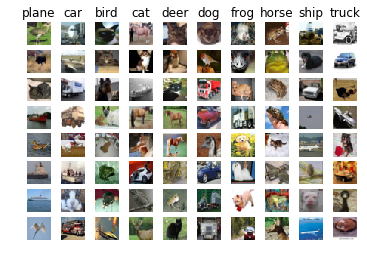

In [13]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

#### Answer:
For the plane classification, there are misclassifications where blue backgrounds were misclassified as plane. A bird flying in the sky is a prime example. Some of these just doesn't make sense. For example, a fire truck and a car is misclassified as a dog. A horse was misclassified as a deer, and I think that makes sense in terms of their general body structure and colors.


## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [14]:
print(X_train_feats.shape)

(49000, 155)


In [16]:
from cs231n.classifiers.neural_net import TwoLayerNet

# input_dim = X_train_feats.shape[1]
# hidden_dim = 500
# num_classes = 10

# net = TwoLayerNet(input_dim, hidden_dim, num_classes)
# best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
def train(hidden_layer_unit_count,
           num_iters,
           learning_rate,
           regularization_strength,
           dropout=None):
    
    input_size = X_train_feats.shape[1]
    num_classes = 10
    
    print(f'training with lr: {learning_rate}, reg: {regularization_strength}, and hidden: {hidden_layer_unit_count}')
    net = TwoLayerNet(input_size,
                      hidden_layer_unit_count,
                      num_classes)
    # Train the network
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                      num_iters=num_iters,
                      batch_size=200,
                      learning_rate=learning_rate, 
                      learning_rate_decay=0.95,
                      reg=regularization_strength, 
                      verbose=True, 
                      dropout=dropout)
    return (net, stats)
    
def run_training(hidden_layer_unit_counts,
                 regularization_strengths,
                 learning_rates,
                 epochs,
                 dropout):
    best_net = None # store the best model into this 
    best_stats = None
    best_val_acc = -1

    batch_size = 200
    num_iters_for_epoch = max(len(X_train) / batch_size, 1)
    num_iters = int(num_iters_for_epoch * epochs)
    results = {}

    for hidden_layer_unit_count in hidden_layer_unit_counts:
        for regularization_strength in regularization_strengths:
            for learning_rate in learning_rates:
                net, stats = train(hidden_layer_unit_count,
                       num_iters,
                       learning_rate,
                       regularization_strength,
                       dropout=dropout)
                val_acc = stats['val_acc_history'][-1]    
                if best_val_acc < val_acc:
                    best_val_acc = val_acc
                    best_net = net
                    best_stats = stats

                train_acc = stats['train_acc_history'][-1]

                results[(learning_rate, regularization_strength)] = (train_acc, val_acc)

    plt.subplot(2, 1, 1)
    plt.plot(best_stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(best_stats['train_acc_history'], label='train')
    plt.plot(best_stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Classification accuracy')
    plt.show()

    print("best val acc:", best_val_acc)
    for lr, reg in sorted(results):
        train_accuracy, val_accuracy = results[(lr, reg)]
        print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                    lr, reg, train_accuracy, val_accuracy))
    return (best_net, best_stats, best_val_acc)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

[3.3935558208120136e-08, 3.4304313185362584e-08, 3.8534751829114237e-07, 6.282107101243354e-07, 8.294632242960809e-06, 7.054812049072417e-06, 8.558915706103731e-05, 3.534449838823059e-05, 0.0007349919004743835, 0.0008728314098095728, 0.005976246599593497, 0.00855238148272766]
[0.00746927286982227, 0.003530225215729455, 0.025985104685226426, 0.09535972771841193, 0.5927617375805809, 0.7065926350949887, 8.05943814109505, 5.9907997674062345, 30.670714970152723, 24.560533541609736, 639.1303333883261, 909.3490718743773, 4677.696259408468, 5391.051592928174]
training with lr: 3.3935558208120136e-08, reg: 0.00746927286982227, and hidden: 500
iteration 0 / 245: loss 2.302591
iteration 50 / 245: loss 2.302592
iteration 100 / 245: loss 2.302591
iteration 150 / 245: loss 2.302591
iteration 200 / 245: loss 2.302591
training with lr: 3.4304313185362584e-08, reg: 0.00746927286982227, and hidden: 500
iteration 0 / 245: loss 2.302591
iteration 50 / 245: loss 2.302591
iteration 100 / 245: loss 2.302591


/Users/jin/workspace/learning/stanford/cs231n/assignments/assignment1/cs231n/classifiers/neural_net.py:110: RuntimeWarning: divide by zero encountered in log
  losses = -np.log(exp_ratios)
/Users/jin/workspace/learning/stanford/cs231n/assignments/assignment1/cs231n/classifiers/neural_net.py:131: RuntimeWarning: divide by zero encountered in true_divide
  grad_ln = 1 / exp_ratios
/Users/jin/workspace/learning/stanford/cs231n/assignments/assignment1/cs231n/classifiers/neural_net.py:131: RuntimeWarning: overflow encountered in true_divide
  grad_ln = 1 / exp_ratios
/Users/jin/workspace/learning/stanford/cs231n/assignments/assignment1/cs231n/classifiers/neural_net.py:143: RuntimeWarning: invalid value encountered in multiply
  dExpPreDot = dln * grad_label_exps_multiply * grad_exp
/Users/jin/workspace/learning/stanford/cs231n/assignments/assignment1/cs231n/classifiers/neural_net.py:155: RuntimeWarning: invalid value encountered in multiply
  dSum = dln * grad_label_exps_multiply * grad_fli

iteration 50 / 245: loss nan
iteration 100 / 245: loss nan
iteration 150 / 245: loss nan
iteration 200 / 245: loss nan
training with lr: 0.00855238148272766, reg: 639.1303333883261, and hidden: 500
iteration 0 / 245: loss 2.828963
iteration 50 / 245: loss nan
iteration 100 / 245: loss nan
iteration 150 / 245: loss nan
iteration 200 / 245: loss nan
training with lr: 3.3935558208120136e-08, reg: 909.3490718743773, and hidden: 500
iteration 0 / 245: loss 3.058822
iteration 50 / 245: loss 3.054396
iteration 100 / 245: loss 3.050001
iteration 150 / 245: loss 3.045632
iteration 200 / 245: loss 3.041287
training with lr: 3.4304313185362584e-08, reg: 909.3490718743773, and hidden: 500
iteration 0 / 245: loss 3.051351
iteration 50 / 245: loss 3.046921
iteration 100 / 245: loss 3.042522
iteration 150 / 245: loss 3.038150
iteration 200 / 245: loss 3.033803
training with lr: 3.8534751829114237e-07, reg: 909.3490718743773, and hidden: 500
iteration 0 / 245: loss 3.054714
iteration 50 / 245: loss 3.

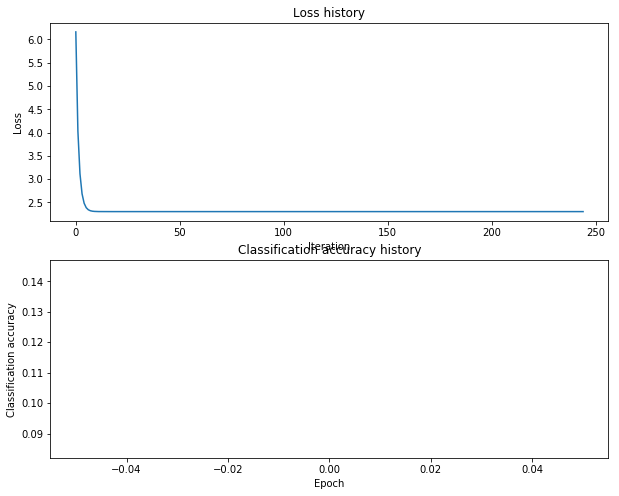

best val acc: 0.144
lr 3.393556e-08 reg 3.530225e-03 train accuracy: 0.090000 val accuracy: 0.090000
lr 3.393556e-08 reg 7.469273e-03 train accuracy: 0.100000 val accuracy: 0.109000
lr 3.393556e-08 reg 2.598510e-02 train accuracy: 0.085000 val accuracy: 0.088000
lr 3.393556e-08 reg 9.535973e-02 train accuracy: 0.090000 val accuracy: 0.092000
lr 3.393556e-08 reg 5.927617e-01 train accuracy: 0.075000 val accuracy: 0.084000
lr 3.393556e-08 reg 7.065926e-01 train accuracy: 0.095000 val accuracy: 0.095000
lr 3.393556e-08 reg 5.990800e+00 train accuracy: 0.075000 val accuracy: 0.097000
lr 3.393556e-08 reg 8.059438e+00 train accuracy: 0.145000 val accuracy: 0.067000
lr 3.393556e-08 reg 2.456053e+01 train accuracy: 0.190000 val accuracy: 0.113000
lr 3.393556e-08 reg 3.067071e+01 train accuracy: 0.130000 val accuracy: 0.123000
lr 3.393556e-08 reg 6.391303e+02 train accuracy: 0.095000 val accuracy: 0.091000
lr 3.393556e-08 reg 9.093491e+02 train accuracy: 0.100000 val accuracy: 0.086000
lr 3.393

<IPython.core.display.Javascript object>

In [30]:
# Trial 1

learning_rates = []
for exponent in range(-8, -2):
    for _ in range(2):
        learning_rates.append(np.random.uniform(10**(exponent), 10**(exponent+1)))

regularization_strengths = []
for exponent in range(-3, 4):
    for _ in range(2):
        regularization_strengths.append(np.random.uniform(10**(exponent), 10**(exponent+1)))
        
hidden_layer_unit_counts = [500]
print(learning_rates)
print(regularization_strengths)
epochs = 1
dropout = 0.6

best_net, best_stats, best_val_acc = run_training(hidden_layer_unit_counts,
                                                  regularization_strengths,   
                                                  learning_rates,
                                                  epochs,   
                                                  dropout)
# End
%notify

[3.317032895355216e-07, 9.023929424688191e-07, 2.5921582267523497e-07, 3.6471098815491907e-06, 6.241526112961109e-06, 4.42514505611211e-06, 1.1405949495731802e-05, 6.789678632831504e-05, 1.309991384291387e-05]
[0.9113166792511638, 0.4920224549569149, 0.3510990944122465, 6.234694375531553, 3.6825885320304135, 5.485741537160918, 54.842937723452465, 69.56016412960784, 88.67015307757251, 190.43353275071547, 543.6824738703849, 765.8482734358594, 6069.693973076433, 7859.340838324573, 5676.508916468854]
training with lr: 3.317032895355216e-07, reg: 0.9113166792511638, and hidden: 500
iteration 0 / 318: loss 2.303338
iteration 50 / 318: loss 2.303338
iteration 100 / 318: loss 2.303338
iteration 150 / 318: loss 2.303338
iteration 200 / 318: loss 2.303338
iteration 250 / 318: loss 2.303338
iteration 300 / 318: loss 2.303338
training with lr: 9.023929424688191e-07, reg: 0.9113166792511638, and hidden: 500
iteration 0 / 318: loss 2.303337
iteration 50 / 318: loss 2.303337
iteration 100 / 318: loss

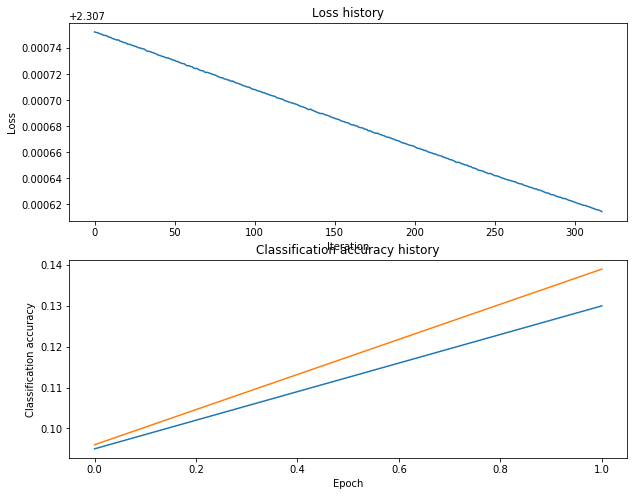

best val acc: 0.139
lr 2.592158e-07 reg 3.510991e-01 train accuracy: 0.095000 val accuracy: 0.112000
lr 2.592158e-07 reg 4.920225e-01 train accuracy: 0.110000 val accuracy: 0.084000
lr 2.592158e-07 reg 9.113167e-01 train accuracy: 0.135000 val accuracy: 0.095000
lr 2.592158e-07 reg 3.682589e+00 train accuracy: 0.100000 val accuracy: 0.136000
lr 2.592158e-07 reg 5.485742e+00 train accuracy: 0.110000 val accuracy: 0.091000
lr 2.592158e-07 reg 6.234694e+00 train accuracy: 0.110000 val accuracy: 0.097000
lr 2.592158e-07 reg 5.484294e+01 train accuracy: 0.125000 val accuracy: 0.089000
lr 2.592158e-07 reg 6.956016e+01 train accuracy: 0.110000 val accuracy: 0.109000
lr 2.592158e-07 reg 8.867015e+01 train accuracy: 0.100000 val accuracy: 0.077000
lr 2.592158e-07 reg 1.904335e+02 train accuracy: 0.075000 val accuracy: 0.120000
lr 2.592158e-07 reg 5.436825e+02 train accuracy: 0.105000 val accuracy: 0.112000
lr 2.592158e-07 reg 7.658483e+02 train accuracy: 0.100000 val accuracy: 0.081000
lr 2.592

<IPython.core.display.Javascript object>

In [32]:
# Trial 2

learning_rates = []
for exponent in range(-7, -4):
    for _ in range(3):
        learning_rates.append(np.random.uniform(10**(exponent), 10**(exponent+1)))

regularization_strengths = []
for exponent in range(-1, 4):
    for _ in range(3):
        regularization_strengths.append(np.random.uniform(10**(exponent), 10**(exponent+1)))
        
hidden_layer_unit_counts = [500]
print(learning_rates)
print(regularization_strengths)
epochs = 1.3
dropout = 0.6

best_net, best_stats, best_val_acc = run_training(hidden_layer_unit_counts,
                                                  regularization_strengths,   
                                                  learning_rates,
                                                  epochs,   
                                                  dropout)
# End
%notify
# lr 8.294632e-06 reg 5.990800e+00 train accuracy: 0.110000 val accuracy: 0.137000
# lr 7.054812e-06 reg 7.469273e-03 train accuracy: 0.100000 val accuracy: 0.137000
# lr 3.853475e-07 reg 5.927617e-01 train accuracy: 0.135000 val accuracy: 0.139000
# lr 3.534450e-05 reg 4.677696e+03 train accuracy: 0.085000 val accuracy: 0.144000

In [29]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.109


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!